In [57]:
from collections import Counter

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
df = pd.read_csv('comments.csv', encoding='utf-8', sep=';', error_bad_lines=False)

Skipping line 20650: expected 6 fields, saw 7



In [37]:
df.columns = ['time', 'profile', 'username', 'plus', 'minus', 'text']

In [38]:
df.fillna('', inplace=True)

In [39]:
df = df[df['minus'] <= 0]

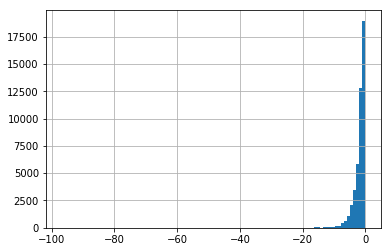

In [40]:
df.minus.hist(bins=100)

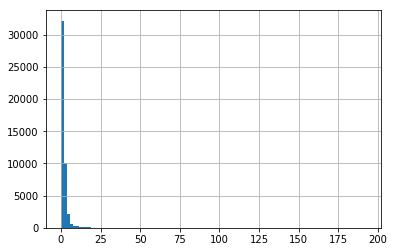

In [41]:
df.plus.hist(bins=100)

In [42]:
df.head()

,time,profile,username,plus,minus,text
0,1499599723000,https://profile.hypercomments.com/7817694,Игорь,0,-16,
1,1499608692000,https://profile.hypercomments.com/2391496,Ал Екс,3,-21,
2,1499610553000,https://profile.hypercomments.com/7844634,Fedaris Gumerov,11,-4,Ты на самом деле ЁБНУТЫЙ..?
3,1499610588000,https://profile.hypercomments.com/7844634,Fedaris Gumerov,3,-2,Ты на самом деле ПРИЁБНУТЫЙ...?
4,1499620277000,https://profile.hypercomments.com/2391496,Ал Екс,1,-20,


In [43]:
df.plus.sum()

69221

In [44]:
df.minus.sum()

-67530

In [45]:
df.plus.describe()

count    46061.000000
mean         1.502811
std          3.880927
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max        192.000000
Name: plus, dtype: float64

In [46]:
df.minus.describe()

count    46061.000000
mean        -1.466099
std          2.625720
min        -97.000000
25%         -2.000000
50%         -1.000000
75%          0.000000
max          0.000000
Name: minus, dtype: float64

In [47]:
# df = df[(df['minus'] < -2) | (df['plus'] > 2)]

In [48]:
def summary(row):
    return int(row['minus']) + int(row['plus'])

df['total'] = df.apply(summary, axis=1)

In [49]:
df = df[(df['total'] > 0) | (df['total'] < 0)]

In [50]:
df = df[df.text != '']

In [51]:
df['is_bot'] = df.total.apply(lambda x: 1 if x < 0 else 0)

In [60]:
counter = Counter()

for i, row in df.iterrows():
    profile = row['profile']
    text = row['text']
    counter.update([(profile, text)])

In [62]:
bot_profiles = set()
for tuple_profile_text, count in counter.most_common():
    if count == 1:
        break
    profile, text = tuple_profile_text
    bot_profiles.add(profile)

In [63]:
len(bot_profiles)

50

In [65]:
df.shape

(25389, 8)

In [81]:
df.ix[df.profile.isin(bot_profiles), 'is_bot'] = 1

/Users/toly/projects/hypercomments_parser/env/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [82]:
df.is_bot.value_counts()

1    19313
0     6076
Name: is_bot, dtype: int64

In [85]:
model = Pipeline([
    ('vectors', FeatureUnion([
        ('chars', TfidfVectorizer(ngram_range=(1, 5), analyzer='char', min_df=10)),
        ('words', TfidfVectorizer(ngram_range=(1, 2), min_df=10)),
    ])),
    ('logistic', LogisticRegression(class_weight='balanced'))
])

In [86]:
for score in cross_val_score(model, df.text, df.is_bot, cv=5):
    print score

0.655443985036
0.722725482473
0.692989365892
0.741579673035
0.715186133543
